In [ ]:
!pip install yfinance
!pip install scikit-learn
import yfinance as yf
import pandas as pd
import os
import numpy as np


if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
sp500.index = pd.to_datetime(sp500.index,utc=True)
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500 = sp500.loc["1990-01-01":].copy()


In [ ]:
def print_table(data):
    print(tabulate(data.tail(5), headers="keys", tablefmt="psql"))
def drop_high_missing_columns(data, threshold=0.8):
    missing_ratio = data.isnull().mean()
    columns_to_drop = missing_ratio[missing_ratio > threshold].index
    data = data.drop(columns_to_drop, axis=1)
    return data
from sklearn.impute import SimpleImputer

def impute_missing_values(data, strategy='mean'):
    imputer = SimpleImputer(strategy=strategy)
    imputed_data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
    return imputed_data

def handle_missing_values(data, method='impute', strategy='mean'):
    if method == 'drop':
        
        data = data.dropna()
    elif method == 'fillna':
       
        data = data.fillna(strategy)
    elif method == 'impute':
      
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy=strategy)
        imputed_data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
        data = imputed_data
    else:
        raise ValueError("Invalid method specified. Choose from 'drop', 'fillna', or 'impute'.")
    
    return data

def clean_data(data):
    
    data = data.dropna()
    
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

   
    data = data.drop_duplicates()

    
    data = data.fillna(method='ffill')
    data=drop_high_missing_columns(data)
    data=handle_missing_values(data)
    print("\n\n-----------Data Cleaning Done----------------\n")
    print_table(data) 
    return data

def preprocess_data(data):
   
    data_min_max_scaled = (data - data.min()) / (data.max() - data.min())

  
    data_standardized = (data_min_max_scaled - data_min_max_scaled.mean()) / data_min_max_scaled.std()
    

    data_preprocessed = np.log1p(data_standardized)
    data_preprocessed_no_nan = handle_missing_values(data_preprocessed, method='impute', strategy='mean')
    print("\n\n----------------Data Preprocessing Done-------------\n")
    print_table(data_preprocessed_no_nan) 
    
    return data_preprocessed_no_nan




print_table(data): This function prints the last 5 rows of a DataFrame data in a tabular format using the tabulate function.

drop_high_missing_columns(data, threshold=0.8): This function calculates the missing ratio for each column in the DataFrame data. It drops the columns that have a missing ratio greater than the specified threshold and returns the updated DataFrame.

impute_missing_values(data, strategy='mean'): This function uses the SimpleImputer class from scikit-learn to impute missing values in the DataFrame data using the specified strategy (default is 'mean'). It returns a new DataFrame with the imputed values.

handle_missing_values(data, method='impute', strategy='mean'): This function handles missing values in the DataFrame data based on the specified method. If method is 'drop', it drops rows with missing values. If method is 'fillna', it fills missing values using the specified strategy. If method is 'impute', it uses the impute_missing_values function to impute missing values. It returns the updated DataFrame.

clean_data(data): This function performs various data cleaning operations on the DataFrame data. It drops rows with missing values, removes outliers using the IQR method, drops duplicated rows, and fills remaining missing values using forward fill. It then prints the cleaned data using the print_table function and returns the cleaned DataFrame.

preprocess_data(data): This function preprocesses the DataFrame data. It performs feature scaling using Min-Max scaling, standardization using Z-score normalization, and log transformation. It then handles missing values using the handle_missing_values function with imputation strategy set to 'mean'. Finally, it prints the preprocessed data using the print_table function and returns the preprocessed DataFrame.

In [ ]:
sma_periods = [5, 20, 50]
ema_periods = [5, 20, 50]
rsi_periods = [14, 28]
macd_periods = [(12, 26), (5, 35), (10, 50)]
bb_periods = [(20, 2)]
stoch_periods = [(14, 3, 3)]
cci_periods = [20]

new_predictors = []

for period in sma_periods:
    column = f"SMA_{period}"
    sp500[column] = sp500["Close"].rolling(window=period).mean()
    new_predictors.append(column)

for period in ema_periods:
    column = f"EMA_{period}"
    sp500[column] = sp500["Close"].ewm(span=period).mean()
    new_predictors.append(column)

for period1, period2 in macd_periods:
    ema1 = sp500["Close"].ewm(span=period1).mean()
    ema2 = sp500["Close"].ewm(span=period2).mean()
    macd = ema1 - ema2
    signal = macd.ewm(span=9).mean()
    column = f"MACD_{period1}_{period2}"
    sp500[column] = macd - signal
    new_predictors.append(column)

for period, std in bb_periods:
    upper_band = sp500["Close"].rolling(window=period).mean() + std * sp500["Close"].rolling(window=period).std()
    lower_band = sp500["Close"].rolling(window=period).mean() - std * sp500["Close"].rolling(window=period).std()
    column = f"BB_{period}"
    sp500[column] = (sp500["Close"] - lower_band) / (upper_band - lower_band)
    new_predictors.append(column)

for k, d, period in stoch_periods:
    low_min = sp500["Low"].rolling(window=period).min()
    high_max = sp500["High"].rolling(window=period).max()
    stoch_k = (sp500["Close"] - low_min) / (high_max - low_min) * 100
    stoch_d = stoch_k.rolling(window=d).mean()
    column = f"Stoch_{k}_{d}_{period}"
    sp500[column] = (stoch_k - stoch_d) / 100
    new_predictors.append(column)

for period in cci_periods:
    tp = (sp500["High"] + sp500["Low"] + sp500["Close"]) / 3
    sma = tp.rolling(window=period).mean()
    md = (tp - sma).abs().rolling(window=period).mean()
    cci = (tp - sma) / (0.015 * md)
    column = f"CCI_{period}"
    sp500[column] = cci
    new_predictors.append(column)
  
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])


sma_periods: A list of periods for calculating the Simple Moving Average (SMA).

ema_periods: A list of periods for calculating the Exponential Moving Average (EMA).

rsi_periods: A list of periods for calculating the Relative Strength Index (RSI).

macd_periods: A list of tuples representing periods for calculating the Moving 

Average Convergence Divergence (MACD). Each tuple contains two periods: fast and slow.

bb_periods: A list of tuples representing periods and standard deviations for calculating the Bollinger Bands (BB).

stoch_periods: A list of tuples representing periods and smoothing factors for calculating the Stochastic Oscillator (Stoch).

cci_periods: A list of periods for calculating the Commodity Channel Index (CCI).

new_predictors: An empty list to store the names of the newly created predictor columns.

In [ ]:
from sklearn.ensemble import RandomForestClassifier



best_params = {'max_depth': 6, 'max_features': 17, 'min_samples_leaf': 91, 'min_samples_split': 184, 'n_estimators': 481}


model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_depth=best_params['max_depth']
)

model = RandomForestClassifier(max_depth= 6, max_features= 17, min_samples_leaf= 91, min_samples_split= 184, n_estimators= 481)

n_estimators: The number of decision trees in the random forest.

max_features: The maximum number of features considered when splitting a node.

min_samples_split: The minimum number of samples required to split an internal node.

min_samples_leaf: The minimum number of samples required to be at a leaf node.

max_depth: The maximum depth of the decision trees.

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    precision_scores = []
    recall_scores = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        precision = precision_score(predictions["Target"], predictions["Predictions"])
        recall = recall_score(predictions["Target"], predictions["Predictions"])
        precision_scores.append(precision)
        recall_scores.append(recall)
        all_predictions.append(predictions)
    
    # Compute average precision and recall scores
    avg_precision = sum(precision_scores) / len(precision_scores)
    avg_recall = sum(recall_scores) / len(recall_scores)
    print(f"Average precision score: {avg_precision}")
    print(f"Average recall score: {avg_recall}")
    
    return pd.concat(all_predictions)

predict function:

Fits a model using the train dataset and specified predictors.
Makes predictions on the test dataset using predict_proba.
Thresholds the predicted probabilities at 0.6 to classify them as class 1 or class 0.
Returns a DataFrame combining the actual target values and the predictions.

backtest function:

Performs rolling window backtesting on the data DataFrame.
Splits the data into training and testing sets based on start and step parameters.
Calls the predict function to make predictions on the testing set using the training set and predictors.
Computes precision and recall scores for the predictions.
Returns a concatenated DataFrame with predictions and actual target values for each iteration.
Computes average precision and recall scores.

In [ ]:
from sklearn.metrics import precision_score, recall_score


predictions = backtest(sp500, model, new_predictors)
precision = precision_score(predictions["Target"], predictions["Predictions"])
print(f"Precision score: {precision}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Average precision score: 0.4358849275245274
Average recall score: 0.051052900813678026
Precision score: 0.5555555555555556


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 backtesting using the backtest function, obtains predictions, calculates the precision score, and prints it.

In [ ]:

predictions

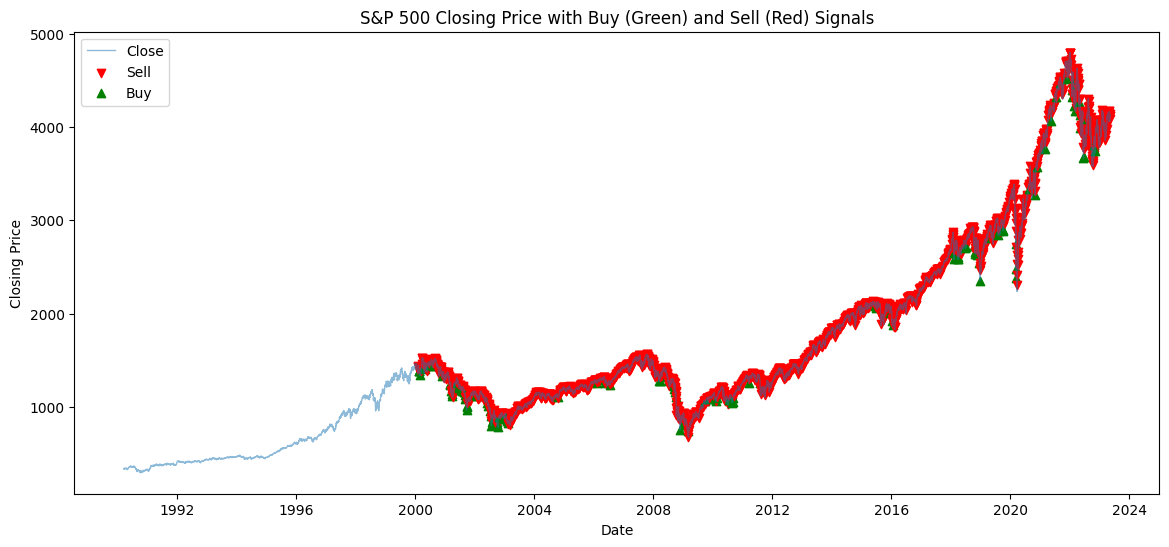

In [ ]:
import matplotlib.pyplot as plt

# Plot the actual closing prices
plt.figure(figsize=(14, 6))
plt.plot(sp500.index, sp500["Close"], label="Close", linewidth=1, alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("S&P 500 Closing Price with Buy (Green) and Sell (Red) Signals")

# Add the predictions as green and red labels for increase and decrease, respectively
for date, actual, prediction in zip(predictions.index, predictions["Target"], predictions["Predictions"]):
    if actual == 1 and prediction == 1:
        plt.scatter(date, sp500.loc[date, "Close"], color="green", marker="^", label="Buy")
    elif actual == 0 and prediction == 0:
        plt.scatter(date, sp500.loc[date, "Close"], color="red", marker="v", label="Sell")

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
plt.legend(*zip(*unique))

plt.show()


the code generates a plot of the S&P 500 closing prices and overlays green and red markers representing "Buy" and "Sell" signals, respectively, based on the predictions.

In [ ]:
import matplotlib.pyplot as plt

# Get user input for the number of days
num_days = int(input("Enter the number of days to display: "))

# Filter the data and predictions for the specified number of days
last_n_days_sp500 = sp500.iloc[-num_days:]
last_n_days_predictions = predictions.iloc[-num_days:]

# Plot the actual closing prices
plt.figure(figsize=(14, 6))
plt.plot(last_n_days_sp500.index, last_n_days_sp500["Close"], label="Close", linewidth=1, alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(f"S&P 500 Closing Price with Buy (Green) and Sell (Red) Signals (Last {num_days} Days)")

# Add the predictions as green and red labels for increase and decrease, respectively
for date, actual, prediction in zip(last_n_days_predictions.index, last_n_days_predictions["Target"], last_n_days_predictions["Predictions"]):
    if actual == 1 and prediction == 1:
        plt.scatter(date, last_n_days_sp500.loc[date, "Close"], color="green", marker="^", label="Buy")
    elif actual == 0 and prediction == 0:
        plt.scatter(date, last_n_days_sp500.loc[date, "Close"], color="red", marker="v", label="Sell")

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
plt.legend(*zip(*unique))

plt.show()


 the code prompts the user to enter the number of days to display, filters the data and predictions for the specified number of days, and generates a plot of the S&P 500 closing prices and overlays green and red markers representing "Buy" and "Sell" signals, respectively, for the last num_days days.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter space to search over
param_dist = {
    "n_estimators": randint(200, 1000),
    "max_features": randint(5, 20),
    "min_samples_split": randint(50, 200),
    "min_samples_leaf": randint(20, 100),
    "max_depth": randint(5, 20)
}

# Create a RandomizedSearchCV object
search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_dist,
    n_iter=10,
    scoring="precision",
    cv=3,
    verbose=2,
    random_state=1,
    n_jobs=-1
)

# Perform the search
search.fit(sp500[new_predictors], sp500["Target"])

# Print the best hyperparameters and corresponding score
print(f"Best score: {search.best_score_}")
print(f"Best parameters: {search.best_params_}")



Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the grid of possible hyperparameters
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create the random forest classifier
model = RandomForestClassifier()

# Use grid search to find the best combination of hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best combination of hyperparameters
print(grid_search.best_params_)
